In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Resize, Grayscale, ToTensor, Normalize

import math

In [0]:
def make_weights_for_balanced_classes(dataset, num_classes):

    count = [0] * num_classes
    for _, label in dataset:
        count[label] += 1

    weight_per_class = [0.0] * num_classes
    N = float(sum(count))

    for i in range(num_classes):
        weight_per_class[i] = N/float(count[i])

    weights = [0.0] * len(dataset)
    for i, (_, label) in enumerate(dataset):
        weights[i] = weight_per_class[label]

    return torch.DoubleTensor(weights)

In [0]:
epochs = 20
lr =0.002
DELAY = 500  # number of steps before turning on additional losses
GROWTH_STEPS = 500

EMBEDDING_DIM = 64
BETA1, BETA2 = 1.0, 0.5
batch_size = 64
test_batch_size = 100
# Transformations
svhn_transformations = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

mnist_transformations = transforms.Compose([
            transforms.Resize(32),
            Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])


svhn_train = datasets.SVHN('../svhn', split='train', download=True, 
                           transform=svhn_transformations)

svhn_test = datasets.SVHN('../svhn', split='test', download=True,
                          transform=svhn_transformations)

mnist_train = datasets.MNIST('../mnist', train=True, download=True,
                            transform=mnist_transformations)

mnist_test = datasets.MNIST('../mnist', train=False, download=True,
                            transform=mnist_transformations)

weights = make_weights_for_balanced_classes(svhn_train, num_classes=10)
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(svhn_train,
                          batch_size=batch_size, sampler=sampler, pin_memory=True,  drop_last=True)
svhn_test_loader = DataLoader(svhn_test,
                         batch_size=test_batch_size, shuffle=True)
mnist_train_loader = DataLoader(mnist_train,
                         batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
mnist_test_loader = DataLoader(mnist_test,
                         batch_size=test_batch_size, shuffle=True)



Using downloaded and verified file: ../svhn/train_32x32.mat
Using downloaded and verified file: ../svhn/test_32x32.mat


In [0]:
class Network(nn.Module):

    def __init__(self, image_size, embedding_dim):
        super(Network, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),
            nn.BatchNorm2d(32), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128), nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        width, height = image_size
        assert width % 8 == 0 and height % 8 == 0
        final_area = (width // 8) * (height // 8)
        self.embedding = nn.Sequential(
            nn.Linear(128 * final_area, embedding_dim),
            nn.BatchNorm1d(embedding_dim),
            nn.LeakyReLU(negative_slope=0.1)
        )
        self.final_area = final_area
        self.embedding_dim = embedding_dim

        def weights_init(m):
            if isinstance(m, (nn.Conv2d, nn.Linear)):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)

        self.apply(weights_init)

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [b, 3, h, w].
            It represents RGB images with pixel values in [0, 1] range.
        Returns:
            a float tensor with shape [b, embedding_dim].
        """
        b = x.size(0)
        x = 2.0*x - 1.0
        x = self.feature_extractor(x)
        x = x.view(b, 128 * self.final_area)
        x = self.embedding(x).view(b, self.embedding_dim)
        return x

In [0]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [0]:
EPSILON = 1e-6


class WalkerVisitLosses(nn.Module):

    def __init__(self):
        super(WalkerVisitLosses, self).__init__()

    def forward(self, a, b, labels_for_a):
        """
        Arguments:
            a: a float tensor with shape [n, d].
            b: a float tensor with shape [m, d].
            labels_for_a: a long tensor with shape [n],
                it has values in {0, 1, ..., num_labels - 1}.
        Returns:
            two float tensors with shape [].
        """
        d = a.size(1)
        p = torch.matmul(a, b.t())  # shape [n, m]
        p /= torch.tensor(d).float().sqrt()

        ab = F.softmax(p, dim=1)  # shape [n, m]
        ba = F.softmax(p.t(), dim=1)  # shape [m, n]
        aba = torch.matmul(ab, ba)  # shape [n, n]
        # note that all rows in `aba` sum to one

        labels = labels_for_a.unsqueeze(0)  # shape [1, n]
        is_same_label = (labels == labels.t()).float()  # shape [n, n]
        label_count = is_same_label.sum(1).unsqueeze(1)  # shape [n, 1]
        targets = is_same_label/label_count  # shape [n, n]
        # note that all rows in `targets` sum to one

        walker_loss = targets * torch.log(EPSILON + aba)  # shape [n, n]
        walker_loss = walker_loss.sum(1).mean(0).neg()

        visit_probability = ab.mean(0)  # shape [m]
        # note that visit_probability.sum() = 1

        m = b.size(0)
        targets = (1.0 / m) * torch.ones_like(visit_probability)
        visit_loss = targets * torch.log(EPSILON + visit_probability)  # shape [m]
        visit_loss = visit_loss.sum(0).neg()

        return walker_loss, visit_loss

In [0]:
def evaluate(model, criterion, loader, device):
    model.eval()
    total_loss = 0.0
    num_hits = 0
    num_samples = 0
    Y = []
    X = []
    for images, targets in loader:

        batch_size = images.size(0)
        images = images.to(device)
        targets = targets.to(device)

        with torch.set_grad_enabled(False):
            logits = model(images)
            loss = criterion(logits, targets)

        _, predicted_labels = logits.max(1)
        num_hits += (targets == predicted_labels).float().sum()
        total_loss += loss * batch_size
        num_samples += batch_size

    loss = total_loss.item() / num_samples
    accuracy = 100. * num_hits.item() / num_samples
    return loss, accuracy

In [0]:
def train(model, device, optimizer, epochs,train_loader, 
          mnist_train_loader ,batch_size, svhn_loader, mnist_test_loader, embedder):
    mnist_len = len(mnist_train_loader)
    svhn_len = len(train_loader)
    num_steps_per_epoch = math.floor(min(svhn_len, mnist_len / batch_size))
    scheduler = CosineAnnealingLR(optimizer, T_max=num_steps_per_epoch * epochs - DELAY,eta_min=1e-6)
    cross_entropy = nn.CrossEntropyLoss()
    association = WalkerVisitLosses()
    i = 0  # iterations
    svhn_train_acc = []
    svhn_test_acc = []
    mnist_test_acc = []
    for e in range(epochs):
        print(f'Epoch # {e+1}')
        model.train()
        for (x_source, y_source), (x_target, _) in zip(train_loader, mnist_train_loader):

            x_source = x_source.to(device)
            x_target = x_target.to(device)
            y_source = y_source.to(device)

            x = torch.cat([x_source, x_target], dim=0)
            embeddings = embedder(x)
            a, b = torch.split(embeddings, batch_size, dim=0)
            logits = classifier(a)
            usual_loss = cross_entropy(logits, y_source)
            walker_loss, visit_loss = association(a, b, y_source)

            if i > DELAY:
                growth = torch.clamp(torch.tensor((i - DELAY)/GROWTH_STEPS).to(device), 0.0, 1.0)
                loss = usual_loss + growth * (BETA1 * walker_loss + BETA2 * visit_loss)
            else:
                loss = usual_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i > DELAY:
                scheduler.step()
            lr = scheduler.get_lr()[0]
            i += 1
        torch.save(model.state_dict(), "model.pt")         

        result1 = evaluate(model, cross_entropy, train_loader, device)
        result2 = evaluate(model, cross_entropy, svhn_test_loader, device)
        result3 = evaluate(model, cross_entropy, mnist_test_loader, device)

        svhn_train_acc.append(result1[1])
        svhn_test_acc.append(result2[1])
        mnist_test_acc.append(result3[1])

        print('Svvht_train: loss {1:.3f} and accuracy {2:.3f}%'.format(e, *result1))
        print('Svhn_test: loss {1:.3f} and accuracy {2:.3f}%'.format(e, *result2))
        print('Mnist_test: loss {1:.3f} and accuracy {2:.3f}%'.format(e, *result3))
        print()
    
    
    return svhn_train_acc, svhn_test_acc, mnist_test_acc


In [0]:
torch.manual_seed(1712380154216581003)


embedder = Network(image_size=(32, 32), embedding_dim=EMBEDDING_DIM).to(device)
classifier = nn.Linear(EMBEDDING_DIM, 10).to(device)
model = nn.Sequential(embedder, classifier)

model.train()

optimizer = optim.Adam(lr=lr, params=model.parameters(), weight_decay=1e-3)


svhn_train_acc, svhn_test_acc, mnist_test_acc = train(model, device, optimizer, 
      epochs, train_loader, mnist_train_loader, batch_size, svhn_test_loader, mnist_test_loader, embedder)


Epoch # 1
Svvht_train: loss 0.553 and accuracy 82.903%
Svhn_test: loss 0.579 and accuracy 82.091%
Mnist_test: loss 1.049 and accuracy 70.420%

Epoch # 2
Svvht_train: loss 0.410 and accuracy 87.346%
Svhn_test: loss 0.425 and accuracy 86.912%
Mnist_test: loss 0.826 and accuracy 83.140%

Epoch # 3
Svvht_train: loss 0.299 and accuracy 91.188%
Svhn_test: loss 0.368 and accuracy 89.256%
Mnist_test: loss 0.802 and accuracy 85.550%

Epoch # 4
Svvht_train: loss 0.242 and accuracy 92.911%
Svhn_test: loss 0.316 and accuracy 90.612%
Mnist_test: loss 0.871 and accuracy 86.030%

Epoch # 5
Svvht_train: loss 0.218 and accuracy 93.746%
Svhn_test: loss 0.302 and accuracy 91.119%
Mnist_test: loss 0.951 and accuracy 86.310%

Epoch # 6
Svvht_train: loss 0.206 and accuracy 94.229%
Svhn_test: loss 0.283 and accuracy 91.752%
Mnist_test: loss 0.915 and accuracy 86.240%

Epoch # 7
Svvht_train: loss 0.209 and accuracy 93.893%
Svhn_test: loss 0.296 and accuracy 91.169%
Mnist_test: loss 0.994 and accuracy 86.330%


Text(0.5, 1.0, 'Domian_adapt : svhn to mnist')

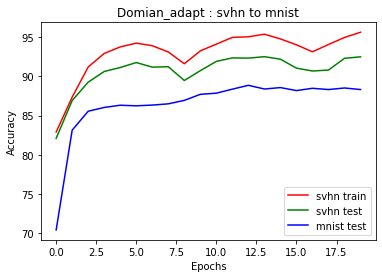

In [0]:
epoch = [i for i in range(epochs)]

### plot learning curve  ###

plt.figure()
plt.plot(epoch, svhn_train_acc, 'r', label='svhn train')
plt.plot(epoch, svhn_test_acc, 'g', label = 'svhn test') 
plt.plot(epoch, mnist_test_acc, 'b', label = 'mnist test')
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Domian_adapt : svhn to mnist')
